In [1]:
!pip install scipy==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 13.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [11688 lines of output]
      /private/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/pip-install-fe1a_bj_/scipy_0f91b36716cc44a783a233316a55b599/setup.py:114: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
        import imp
      /private/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/pip-install-fe1a_bj_/scipy_0f91b36716cc44a783a233316a55b599/setup.py:468: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recomm

In [3]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import ElasticNetCV as en
from statsmodels.tsa.stattools import adfuller as adf
import os

## Save future files to your drive
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# %cd "/content/drive/My Drive/FirmAI/FinML/Data/Commodity"



In [4]:
import pandas as pd

df=pd.read_csv("https://storage.googleapis.com/public-quant/course//content/brent%20crude%20nokjpy.csv")
df.set_index(pd.to_datetime(df[list(df.columns)[0]]),inplace=True)
del df[list(df.columns)[0]]

In [5]:
df.head()

,nok,usd,eur,gbp,brent,gdp yoy,interest rate
﻿date,,,,,,,
2013-04-25,16.901885,99.255002,129.165590,153.186274,10263.95955,NaN,NaN
2013-04-26,16.760666,98.050001,127.746551,151.768098,10114.83800,NaN,NaN
2013-04-29,16.818312,97.765004,128.073770,151.538112,10148.98465,NaN,NaN
2013-04-30,16.882766,97.424999,128.287364,151.331719,9973.39725,NaN,1.5
2013-05-01,16.883051,97.389997,128.353228,151.492198,9734.13050,NaN,1.5


In [27]:
df['brent'][1:5].mean()

9992.8376

In [25]:
df['brent'].rolling(window=4).mean()[:8]

date
2013-04-25             NaN
2013-04-26             NaN
2013-04-29             NaN
2013-04-30    10125.294862
2013-05-01     9992.837600
2013-05-02     9983.053163
2013-05-03    10025.421163
2013-05-06    10151.302775
Name: brent, dtype: float64

In [28]:
## List of features that don't make sense but works
## Shift the target, never the features.
## Correlation catcher
## A hand engineered feature that weights N rolling averages of two variables and find
## .. the rolling correlations of the rolling averages
## If the bb correlation with response is bigger than the cc coefficient, probably causal
import numpy as np


for fact in [40]:
  b=2
  g=0
  keep = []
  for r in range(fact):
    b = b**(1+((10/fact)/np.log(fact)))
    #print("b:", b)
    keep.append(b)
    g = g + b
    #print("g:", g)
    df['brent_'+str(r)] = df['brent'].rolling(window=fact).mean().bfill() 
    #shift by "fact" size window, calculate the mean of each window and sotre the value into
    #the idx = fact value + ith iteration (EX in above 2 cells)
    df['nok'+str(r)] = df['nok'].rolling(window=fact).mean().bfill()
    #do the same for another feature(norwegan currency)
    df['cc_'+str(r)] = df['brent_'+str(r)].rolling(fact).corr(df['nok'+str(r)]).bfill() #bfill: fill nan values
    #do the same, calc corr btw 2 variables by size=fact, then shift the window
    #calculate the correlation coefficient of oild prices and nok currency
    #print("correlation coefficient:", df['cc_'+str(r)])

    del df['nok'+str(r)], df['brent_'+str(r)] # for clean up purpose

  arr = np.log(np.array(keep))
  #logarithmic scaling of the features, which is a common transformation 
  #to normalize data or to handle skewed data distributions.
  #print("arr:", arr)
  arr = arr/arr.sum()
  #weighted the arr by calculating percentage
  #print("arr pct:", arr)
  arr = arr[::-1]

  for it,ar in enumerate(arr):
    print("it:", it)
    print("ar:", ar)
    df['cc_'+str(it)] = df['cc_'+str(it)]*ar
    if it==0:
      df['cc_weighted_'+str(fact)] = 0
    df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)] + df['cc_'+str(it)]
    del df['cc_'+str(it)]
    print("correlation coefficient weighted by pct:", df['cc_weighted_'+str(fact)])
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].bfill()
  print("cc weighted after bfil:", df['cc_weighted_'+str(fact)])



  

it: 0
ar: 0.0684376497146285
correlation coefficient weighted by pct: ﻿date
2013-04-25    0.068438
2013-04-26    0.068438
2013-04-29    0.068438
2013-04-30    0.068438
2013-05-01    0.068438
                ...   
2018-04-18    0.057618
2018-04-19    0.055091
2018-04-20    0.051854
2018-04-23    0.047699
2018-04-24    0.042429
Name: cc_weighted_40, Length: 1289, dtype: float64
it: 1
ar: 0.06409392388397701
correlation coefficient weighted by pct: ﻿date
2013-04-25    0.132532
2013-04-26    0.132532
2013-04-29    0.132532
2013-04-30    0.132532
2013-05-01    0.132532
                ...   
2018-04-18    0.111579
2018-04-19    0.106686
2018-04-20    0.100417
2018-04-23    0.092370
2018-04-24    0.082165
Name: cc_weighted_40, Length: 1289, dtype: float64
it: 2
ar: 0.06002589358306018
correlation coefficient weighted by pct: ﻿date
2013-04-25    0.192557
2013-04-26    0.192557
2013-04-29    0.192557
2013-04-30    0.192557
2013-05-01    0.192557
                ...   
2018-04-18    0.162115
2

In [16]:
for line in range(len(df['cc_0'])):
    if df['cc_0'].iloc[line] != df['cc_33'].iloc[line]:
        print('diff')


In [32]:
## Shift the target, never the features.
## Correlation catcher
## A hand engineered feature that weights N rolling averages of two variables and find
## .. the rolling correlations of the rolling averages
## If the cc correlation with response is bigger than the bb coefficient, probably causal
## If bb is larger there is lagged causality
## the best techniques to confirm causality would in fact be to look at prediction success.


for fact in [2,3,5,10,20,40,60,80,120,150,200]:
  b=2
  g=0
  keep = []
  for r in range(fact):
    b = b**(1+((10/fact)/np.log(fact)))
    keep.append(b)
    g = g + b
    df['brent_'+str(r)] = df['brent'].rolling(window=2+r).mean().bfill()
    df['nok'+str(r)] = df['nok'].rolling(window=2+r).mean().bfill()
    #now try for windows with inconsistant sizes
    df['cc_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()
    #print("cc:", df['cc_'+str(r)])
    df['bb_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()
    #print("bb:", df['bb_'+str(r)])


    del df['nok'+str(r)], df['brent_'+str(r)]


  arr = np.log(np.array(keep))
  arr = arr/arr.sum()

  for it,ar in enumerate(arr):
    df['cc_'+str(it)] = df['cc_'+str(it)]*ar
    if it==0:
      df['cc_weighted_'+str(fact)] = 0
    df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)] + df['cc_'+str(it)]
    del df['cc_'+str(it)]
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['cc_weighted_'+str(fact)] = df['cc_weighted_'+str(fact)].bfill()

  dar = arr[::-1].copy()
  for it,ar in enumerate(dar):
    df['bb_'+str(it)] = df['bb_'+str(it)]*ar
    if it==0:
      df['bb_weighted_'+str(fact)] = 0
    df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)] + df['bb_'+str(it)]
    del df['bb_'+str(it)]
  df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)].replace(np.inf,np.nan).replace(-np.inf,np.nan)
  df['bb_weighted_'+str(fact)] = df['bb_weighted_'+str(fact)].bfill()
  df['causal_size_step'+str(fact)] = df['bb_weighted_'+str(fact)] - df['cc_weighted_'+str(fact)]




/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_82578/2428949631.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cc_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()
/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_82578/2428949631.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bb_'+str(r)] = df['brent_'+str(r)].rolling(2+r).corr(df['nok'+str(r)]).bfill()
/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_82578/2428949631.py:18: PerformanceWarning: DataFra

In [33]:
df.sum()

nok                    1.911090e+04
usd                    1.417756e+05
eur                    1.687475e+05
gbp                    2.078402e+05
brent                  9.708692e+06
gdp yoy                3.372000e+01
interest rate          1.235250e+03
cc_weighted_40         4.644986e+02
cc_weighted_2          4.166537e+02
bb_weighted_2          3.554804e+02
causal_size_step2     -6.117327e+01
cc_weighted_3          4.121278e+02
bb_weighted_3          3.648855e+02
causal_size_step3     -4.724238e+01
cc_weighted_5          4.331537e+02
bb_weighted_5          3.801708e+02
causal_size_step5     -5.298282e+01
cc_weighted_10         4.217745e+02
bb_weighted_10         4.011829e+02
causal_size_step10    -2.059162e+01
cc_weighted_20         4.604777e+02
bb_weighted_20         4.190405e+02
causal_size_step20    -4.143715e+01
bb_weighted_40         4.407486e+02
causal_size_step40    -2.375000e+01
cc_weighted_60         3.854951e+02
bb_weighted_60         4.359705e+02
causal_size_step60     5.047

In [34]:
### This to me shows that in the short run the NOKs exchange rate change in expectation of a change
### of the oil price, oil is a lagging indicator, but oil becomes a leading indicator from 60 time steps
#(at 60 time steps, casual for brent and nok is 0.25 and 0.27)
### onwards. Can be seen in the middle chart a few code blocks below.

#lagging indicators confirm long-term trends rather than predict them.
#meaning that fluctuations in oil prices tend to be reflected in the NOK after this period.  
df.corr()

,nok,usd,eur,gbp,brent,gdp yoy,interest rate,cc_weighted_40,cc_weighted_2,bb_weighted_2,...,causal_size_step80,cc_weighted_120,bb_weighted_120,causal_size_step120,cc_weighted_150,bb_weighted_150,causal_size_step150,cc_weighted_200,bb_weighted_200,causal_size_step200
nok,1.000000,-0.259508,0.803596,0.582291,0.896812,0.258060,0.948522,-0.152727,-0.056319,-0.064972,...,0.222431,-0.266833,-0.301001,0.076682,-0.309703,-0.337553,0.117861,-0.431810,-0.394152,0.198344
usd,-0.259508,1.000000,0.122163,0.502560,-0.550984,0.330808,-0.284277,0.247492,0.026735,0.021255,...,-0.468881,0.744953,0.624149,-0.413169,0.719644,0.716764,-0.337405,0.713011,0.780752,-0.163390
eur,0.803596,0.122163,1.000000,0.758971,0.633535,0.550526,0.695060,-0.138690,-0.059551,-0.057299,...,0.051957,0.039383,-0.128542,-0.170598,0.040974,-0.097388,-0.149119,-0.060080,-0.091862,-0.019170
gbp,0.582291,0.502560,0.758971,1.000000,0.275338,0.378526,0.591654,0.014318,-0.005235,-0.010576,...,-0.167402,0.371318,0.199710,-0.308521,0.405137,0.276189,-0.309637,0.346797,0.323885,-0.150035
brent,0.896812,-0.550984,0.633535,0.275338,1.000000,0.157756,0.837671,-0.256806,-0.091345,-0.087462,...,0.280591,-0.472380,-0.502287,0.163913,-0.522360,-0.560726,0.206880,-0.643510,-0.632387,0.238744
gdp yoy,0.258060,0.330808,0.550526,0.378526,0.157756,1.000000,0.100783,-0.152517,0.114226,0.107809,...,-0.029731,0.100661,-0.086909,-0.188418,0.101711,-0.045091,-0.162902,0.052234,-0.015553,-0.093440
interest rate,0.948522,-0.284277,0.695060,0.591654,0.837671,0.100783,1.000000,-0.148707,-0.023259,-0.035662,...,0.228836,-0.274171,-0.275575,0.109069,-0.289025,-0.310576,0.113190,-0.397080,-0.363488,0.179868
cc_weighted_40,-0.152727,0.247492,-0.138690,0.014318,-0.256806,-0.152517,-0.148707,1.000000,0.018266,0.004990,...,0.087265,0.096257,0.715590,0.531307,0.018600,0.599846,0.537727,0.040691,0.472974,0.531860
cc_weighted_2,-0.056319,0.026735,-0.059551,-0.005235,-0.091345,0.114226,-0.023259,0.018266,1.000000,0.441720,...,0.124020,0.003592,0.113720,0.099957,0.002269,0.088039,0.079570,-0.002102,0.061774,0.081423
bb_weighted_2,-0.064972,0.021255,-0.057299,-0.010576,-0.087462,0.107809,-0.035662,0.004990,0.441720,1.000000,...,0.107645,0.009756,0.097710,0.077040,0.016690,0.079506,0.051285,0.017882,0.061930,0.049400


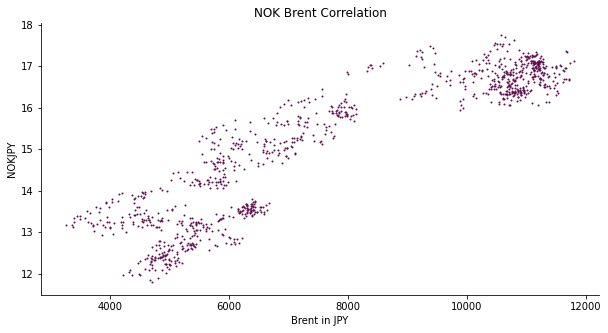

In [ ]:
#identification
#first of first, using scatter plot to visualize the correlation
#lets denote data from 2013-4-25 to 2017-4-25 as estimation horizon/training set
#lets denote data from 2017-4-25 to 2018-4-25 as validation horizon/testing set
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(df['brent'][df.index<'2017-04-25'],df['nok'][df.index<'2017-04-25'],s=1,c='#5f0f4e')

plt.title('NOK Brent Correlation')
plt.xlabel('Brent in JPY')
plt.ylabel('NOKJPY')
plt.show()

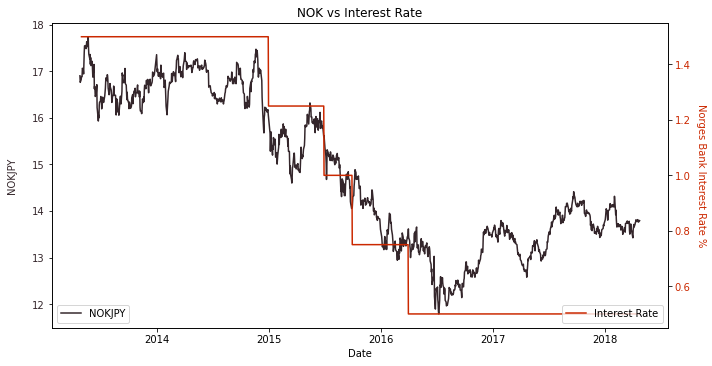

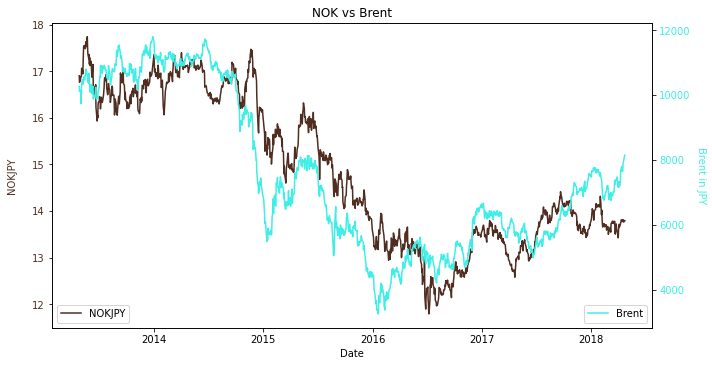

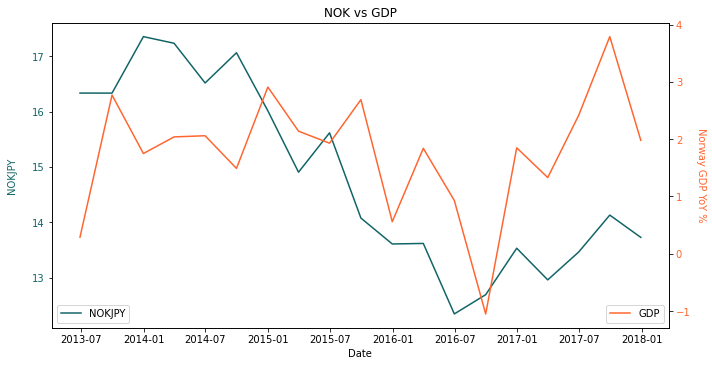

In [ ]:
df.tail()#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):

    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)


    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

#nok vs ir
dual_axis_plot(df.index,df['nok'],df['interest rate'],
               fst_color='#34262b',sec_color='#cb2800',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Norges Bank Interest Rate %',
               legend1='NOKJPY',legend2='Interest Rate',
               grid=False,title='NOK vs Interest Rate')

#nok vs brent
dual_axis_plot(df.index,df['nok'],df['brent'],
               fst_color='#4f2d20',sec_color='#3feee6',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Brent in JPY',
               legend1='NOKJPY',legend2='Brent',
               grid=False,title='NOK vs Brent')

#nok vs gdp
#cuz gdp is released quarterly
#we need to convert nok into quarterly data as well
ind=df['gdp yoy'].dropna().index
dual_axis_plot(df.loc[ind].index,
               df['nok'].loc[ind],
               df['gdp yoy'].dropna(),
               fst_color='#116466',sec_color='#ff652f',
               fig_size=(10,5),x_label='Date',
               y_label1='NOKJPY',y_label2='Norway GDP YoY %',
               legend1='NOKJPY',legend2='GDP',
               grid=False,title='NOK vs GDP')


In [35]:
df['interest rate']

date
2013-04-25    NaN
2013-04-26    NaN
2013-04-29    NaN
2013-04-30    1.5
2013-05-01    1.5
             ... 
2018-04-18    0.5
2018-04-19    0.5
2018-04-20    0.5
2018-04-23    0.5
2018-04-24    0.5
Name: interest rate, Length: 1289, dtype: float64

In [36]:
df = df.ffill().fillna(df.mean()) ## this filling operations can be vastly improved (stay tuned)

In [37]:
# You don't have to shift, you are not predicting next day return, just establishing fundamental relationship
# df['nok'][df.index<'2017-04-25'].shift(1).head()

In [40]:
y

date
2013-04-25    16.901885
2013-04-26    16.901885
2013-04-29    16.760666
2013-04-30    16.818312
2013-05-01    16.882766
                ...    
2017-04-18    12.726046
2017-04-19    12.739178
2017-04-20    12.687538
2017-04-21    12.680378
2017-04-24    12.580594
Name: nok, Length: 1031, dtype: float64

In [41]:
x0

,usd,gbp,eur,brent,causal_size_step200,causal_size_step60,causal_size_step20,causal_size_step10
﻿date,,,,,,,,
2013-04-25,99.255002,153.186274,129.165590,10263.95955,0.296493,0.798929,9.183343e-11,-6.984191e-12
2013-04-26,98.050001,151.768098,127.746551,10114.83800,0.296493,0.798929,9.183343e-11,-6.984191e-12
2013-04-29,97.765004,151.538112,128.073770,10148.98465,0.296493,0.798929,9.183343e-11,-6.984191e-12
2013-04-30,97.424999,151.331719,128.287364,9973.39725,0.277827,0.721020,-2.837801e-01,-5.982491e-01
2013-05-01,97.389997,151.492198,128.353228,9734.13050,0.260968,0.653124,-5.017568e-01,-9.635292e-01
...,...,...,...,...,...,...,...,...
2018-04-18,107.234995,152.299726,132.687587,7879.62780,-0.172180,0.068509,2.503812e-01,-1.174273e-01
2018-04-19,107.374998,151.308821,132.564459,7922.12750,-0.177513,-0.002574,-1.902876e-01,-7.713788e-01
2018-04-20,107.665006,150.772710,132.301382,7973.66990,-0.192966,-0.096911,-6.028701e-01,-1.238876e+00


In [39]:
#Now we do our linear regression
x0=pd.concat([df['usd'],df['gbp'],df['eur'],df['brent'],df['causal_size_step200'],df['causal_size_step60'],df['causal_size_step20'],df['causal_size_step10']],axis=1)
x1=sm.add_constant(x0)
x=x1[x1.index<'2017-04-25']
y=df['nok'][df.index<'2017-04-25'].shift(1).bfill()

model=sm.OLS(y,x).fit()
print(model.summary(),'\n')

                            OLS Regression Results                            
Dep. Variable:                    nok   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2770.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:26:55   Log-Likelihood:                -380.40
No. Observations:                1031   AIC:                             778.8
Df Residuals:                    1022   BIC:                             823.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0662    

Sometimes condition numbers are used (see the appendix). An informal rule of thumb is that if the condition number is 15, multicollinearity is a concern; if it is greater than 30 multicollinearity is a very serious concern. (But again, these are just informal rules of thumb.)

In [43]:
#from the summary (above) you can tell there is multicollinearity
#the condition number is skyrocketing
#alternatively, i can use elastic net regression to achieve the convergence

#Coefficients that are exactly zero suggest that the corresponding feature 
#was completely removed by the L1 penalty (Lasso component), which can help 
#with feature selection in the presence of multicollinearity or when wanting to reduce model complexity.
m=en(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10],
     l1_ratio=[.01, .1, .5, .9, .99],  max_iter=5000).fit(x0[x0.index<'2017-04-25'], y)
print(m.intercept_,m.coef_)

3.8681806064472433 [ 0.00288207  0.02039073  0.0282364   0.00049658  0.          0.
 -0.         -0.        ]


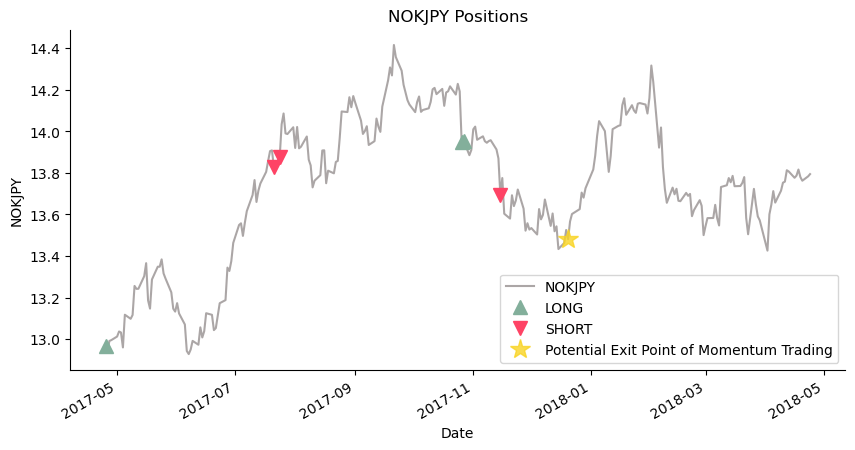

In [44]:
#calculate the fitted value of nok
df['sk_fit']=(df['usd']*m.coef_[0]+df['gbp']*m.coef_[1]+
                 df['eur']*m.coef_[2]+df['brent']*m.coef_[3]+m.intercept_)


# In[6]:


#getting the residual
df['sk_residual']=df['nok']-df['sk_fit']


#one can always argue what if we eliminate some regressors
#in econometrics, if adding extra variables do not decrease adjusted r squared
#or worsen AIC, BIC
#we should include more information as long as it makes sense

#lets generate signals based on the elastic net
#we set one sigma of the residual as thresholds
#two sigmas of the residual as stop orders
#which is common practise in statistics
upper=np.std(df['sk_residual'][df.index<'2017-04-25'])
lower=-upper

signals=pd.concat([df[i] for i in ['nok', 'usd', 'eur', 'gbp', 'brent', 'sk_fit','sk_residual']], \
                  axis=1)[df.index>='2017-04-25']
signals['fitted']=signals['sk_fit']
del signals['sk_fit']

signals['upper']=signals['fitted']+upper
signals['lower']=signals['fitted']+lower
signals['stop profit']=signals['fitted']+2*upper #2 standard deviation
signals['stop loss']=signals['fitted']+2*lower
signals['signals']=0

#while doing a traversal
#we apply the rules mentioned before
#if actual price goes beyond upper threshold
#we take a short and bet on its reversion process
#vice versa
#we use cumsum to make sure our signals only get generated
#for the first time condions are met
#when actual price hits the stop order boundary
#we revert our positions
#u may wonder whats next for breaking the boundary
#well, we stop the signal generation algorithm
#we need to recalibrate our model or use other trend following strategies

index=list(signals.columns).index('signals')

for j in range(len(signals)):

    if signals['nok'].iloc[j]>signals['upper'].iloc[j]:
        signals.iloc[j,index]=-1

    if signals['nok'].iloc[j]<signals['lower'].iloc[j]:
        signals.iloc[j,index]=1

    signals['cumsum']=signals['signals'].cumsum()

    if signals['cumsum'].iloc[j]>1 or signals['cumsum'].iloc[j]<-1:
        signals.iloc[j,index]=0 #ensure only hit once

    if signals['nok'].iloc[j]>signals['stop profit'].iloc[j]:
        signals['cumsum']=signals['signals'].cumsum()
        signals.iloc[j,index]=-signals['cumsum'].iloc[j]+1
        signals['cumsum']=signals['signals'].cumsum()
        break

    if signals['nok'].iloc[j]<signals['stop loss'].iloc[j]:
        signals['cumsum']=signals['signals'].cumsum()
        signals.iloc[j,index]=-signals['cumsum'].iloc[j]-1
        signals['cumsum']=signals['signals'].cumsum()
        break


# In[9]:


#next, we plot the usual positions as the first figure
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

signals['nok'].plot(label='NOKJPY',c='#594f4f',alpha=0.5)
ax.plot(signals.loc[signals['signals']>0].index,
         signals['nok'][signals['signals']>0],
         lw=0,marker='^',c='#83af9b',label='LONG', markersize=10)
ax.plot(signals.loc[signals['signals']<0].index,
         signals['nok'][signals['signals']<0],
         lw=0,marker='v',c='#fe4365',label='SHORT', markersize=10)
ax.plot(pd.to_datetime('2017-12-20'),
         signals['nok'].loc['2017-12-20'],
         lw=0,marker='*',c='#f9d423', markersize=15, alpha=0.8,
         label='Potential Exit Point of Momentum Trading')

# plt.axvline('2017/11/15',linestyle=':',c='k',label='Exit')
plt.legend()
plt.title('NOKJPY Positions')
plt.ylabel('NOKJPY')
plt.xlabel('Date')
plt.show()


In [47]:
signals.head()

,nok,usd,eur,gbp,brent,sk_residual,fitted,upper,lower,stop profit,stop loss,signals,cumsum
﻿date,,,,,,,,,,,,,
2017-04-25,12.968991,111.095002,121.381319,142.663528,5788.04950,-0.429969,13.398960,13.773962,13.023957,14.148964,12.648955,1,1
2017-04-26,12.937447,111.055004,121.087365,142.653352,5754.87010,-0.436413,13.373861,13.748863,12.998858,14.123865,12.623856,0,1
2017-04-27,12.991062,111.265003,120.977498,143.575018,5723.47160,-0.383503,13.374565,13.749568,12.999563,14.124570,12.624560,0,1
2017-04-28,12.995114,111.544996,121.550991,144.456482,5770.22285,-0.437641,13.432755,13.807757,13.057752,14.182760,12.682750,0,1
2017-05-01,13.012362,111.839997,121.899189,144.112985,5761.99680,-0.419986,13.432348,13.807350,13.057346,14.182353,12.682343,0,1


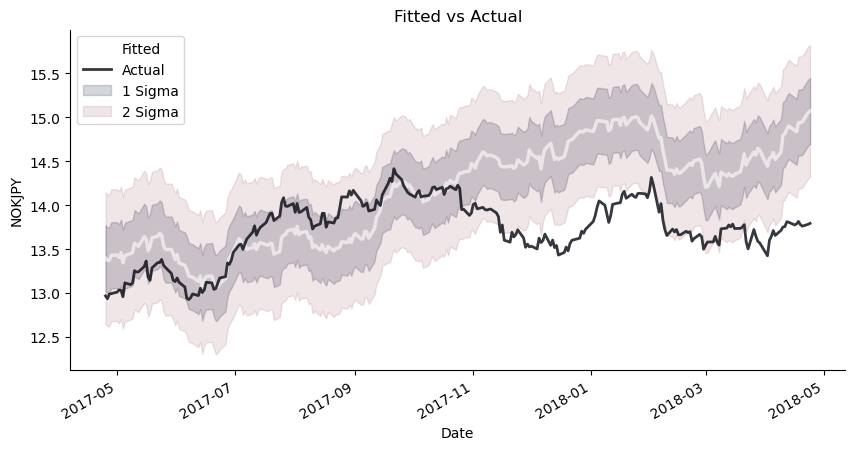

In [48]:
#the second figure explores thresholds and boundaries for signal generation
#we can see after 2017/11/15, nokjpy price went skyrocketing
#as a data scientist, we must ask why?
#is it a problem of our model identification
#or the fundamental situation of nokjpy or oil changed

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

signals['fitted'].plot(lw=2.5,label='Fitted',c='w',alpha=0.6)
signals['nok'].plot(lw=2,label='Actual',c='#04060f',alpha=0.8)
ax.fill_between(signals.index,signals['upper'],
                signals['lower'],alpha=0.2,label='1 Sigma',color='#2a3457')
ax.fill_between(signals.index,signals['stop profit'],
                signals['stop loss'],alpha=0.1,label='2 Sigma',color='#720017')

plt.legend(loc='best')
plt.title('Fitted vs Actual')
plt.ylabel('NOKJPY')
plt.xlabel('Date')
plt.show()

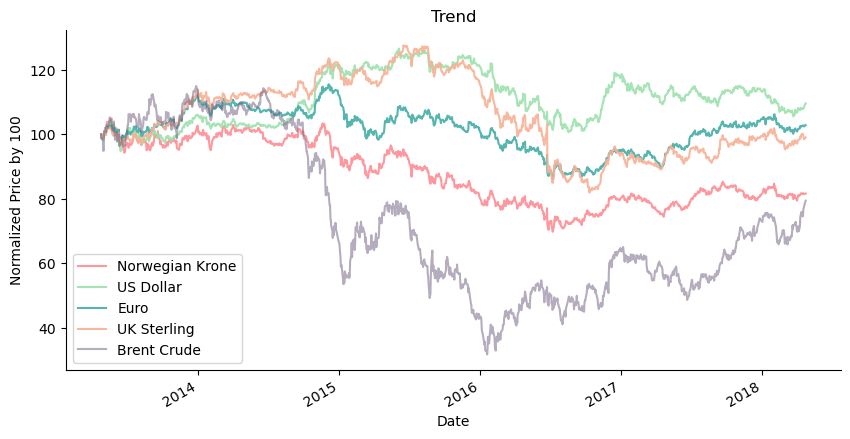

In [54]:
#if we decompose nokjpy into long term trend and short term random process
#we could clearly see that brent crude price has dominated short term random process
#so what changed the long term trend?
#there are a few possible reasons
#saudi and iran endorsed an extension of production caps on that particular date
#donald trump got elected as potus so he would encourage a depreciated us dollar
#which ultimately pushed up the oil price

# In[12]:

#lets normalize all prices by 100
#its easy to see that nok follows euro
#and economics explanation would be norway is in eea
#its economy heavily relies on eu
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(df['nok']/df['nok'][0]*100).plot(c='#ff8c94',label='Norwegian Krone',alpha=0.9)
(df['usd']/df['usd'][0]*100).plot(c='#9de0ad',label='US Dollar',alpha=0.9)
(df['eur']/df['eur'][0]*100).plot(c='#45ada8',label='Euro',alpha=0.9)
(df['gbp']/df['gbp'][0]*100).plot(c='#f8b195',label='UK Sterling',alpha=0.9)
(df['brent']/df['brent'][0]*100).plot(c='#6c5b7c',label='Brent Crude',alpha=0.5)

plt.legend(loc='best')
plt.ylabel('Normalized Price by 100')
plt.xlabel('Date')
plt.title('Trend')
plt.show()

In [55]:
#that still doesnt sound convincable
#lets try cointegration test
#academically we should use johansen test which works on multi dimensions
#unfortunately, there is no johansen test in statsmodels (at the time i wrote this script)
#well, here we go again
#we have to use Engle-Granger two step!


x2=df['eur'][df.index<'2017-04-25']
x3=sm.add_constant(x2)

model=sm.OLS(y,x3).fit() #y is nok
ero=model.resid

print(adf(ero))#adf: check for stationary of time seires
print(model.summary())
# suggests that the residuals from the regression may not be stationary. 
#Consequently, we do not have sufficient evidence to conclude that the 
#time series are cointegrated based on this ADF test.

(-2.6304210139887516, 0.08687143224904875, 3, 1027, {'1%': -3.4367333690404767, '5%': -2.8643583648001925, '10%': -2.568270618452702}, -757.8391479922132)
                            OLS Regression Results                            
Dep. Variable:                    nok   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     2787.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          4.25e-295
Time:                        23:03:05   Log-Likelihood:                -1314.0
No. Observations:                1031   AIC:                             2632.
Df Residuals:                    1029   BIC:                             2642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

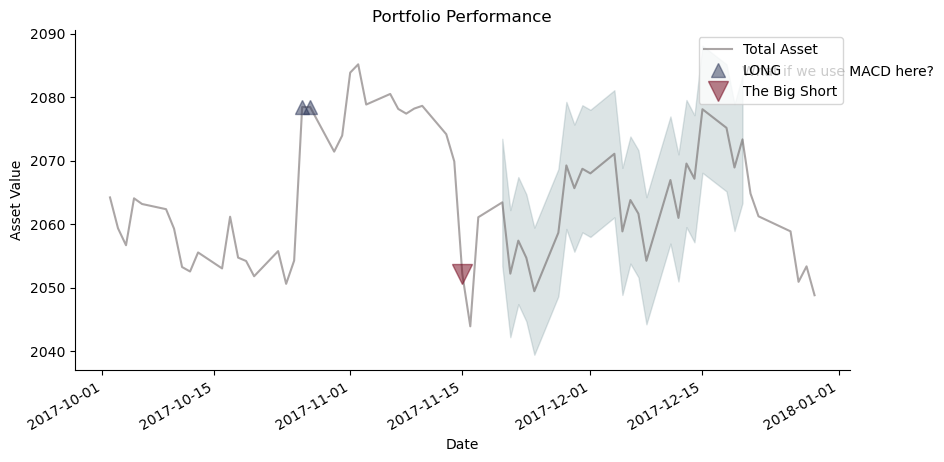

In [58]:
#unfortunately, the residual hasnt even reached 90% confidence interval
#we cant conclude any cointegration from the test
#still, from the visualization
#we can tell nok and eur are somewhat correlated
#our rsquared suggested euro has the power of 73% explanation on nok

#then lets do a pnl analysis
capital0=2000 #initial capital
positions=100
portfolio=pd.DataFrame(index=signals.index)
portfolio['holding']=signals['nok']*signals['cumsum']*positions
portfolio['cash']=capital0-(signals['nok']*signals['signals']*positions).cumsum()
portfolio['total asset']=portfolio['holding']+portfolio['cash']
portfolio['signals']=signals['signals']


# In[15]:


portfolio=portfolio[portfolio.index>'2017-10-01']
portfolio=portfolio[portfolio.index<'2018-01-01']


# In[16]:


#we plot how our asset value changes over time
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

portfolio['total asset'].plot(c='#594f4f',alpha=0.5,label='Total Asset')
ax.plot(portfolio.loc[portfolio['signals']>0].index,portfolio['total asset'][portfolio['signals']>0],
         lw=0,marker='^',c='#2a3457',label='LONG',markersize=10,alpha=0.5)
ax.plot(portfolio.loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],
         lw=0,marker='v',c='#720017',label='The Big Short',markersize=15,alpha=0.5)
ax.fill_between(portfolio['2017-11-20':'2017-12-20'].index,
                 (portfolio['total asset']+np.std(portfolio['total asset']))['2017-11-20':'2017-12-20'],
                 (portfolio['total asset']-np.std(portfolio['total asset']))['2017-11-20':'2017-12-20'],
                 alpha=0.2, color='#547980')

plt.text(pd.to_datetime('2017-12-20'),
          (portfolio['total asset']+np.std(portfolio['total asset'])).loc['2017-12-20'],
          'What if we use MACD here?')
# plt.axvline('2017/11/15',linestyle=':',label='Exit',c='#ff847c')
plt.legend()
plt.title('Portfolio Performance')
plt.ylabel('Asset Value')
plt.xlabel('Date')
plt.show()

In [59]:
#surprising when our model is valid for prediction
#its difficult to make money from thresholds oscillating
#when actual price goes beyond stop order boundary
#that is basically the most profitable trade ever
#best to follow up with a momentum strategy
#maybe this is not a statistical arbitrage after all
#the model is a trend following entry indicator
import copy


def oil_money(dataset):

    df=copy.deepcopy(dataset)

    df['signals']=0
    df['pos2 sigma']=0.0
    df['neg2 sigma']=0.0
    df['pos1 sigma']=0.0
    df['neg1 sigma']=0.0
    df['forecast']=0.0

    return df

def signal_generation(dataset,x,y,method, \
                      holding_threshold=10, \
                      stop=0.5,rsquared_threshold=0.7, \
                      train_len=50):

    df=method(dataset)

    #variable holding takes 3 values, -1,0,1
    #0 implies no holding positions
    #1 implies long, -1 implies short
    #when we wanna clear our positions
    #we just reverse the sign of holding
    #which is quite convenient
    holding=0

    #trained is a boolean value
    #it indicates whether the current model is valid
    #in another word,when trained==True, r squared is over 0.7 by default
    #and the regressand is within two sigma range from the fitted value
    trained=False

    #counter counts the days of position holding
    counter=0


    for i in range(train_len,len(df)):

        #when we have uncleared positions
        if holding!=0:

            #when counter exceeds holding threshold
            #we clear our positions and reset all the parameters
            if counter>holding_threshold:
                df.at[i,'signals']=-holding
                holding=0
                trained=False
                counter=0

                #we use continue to skip this round of iteration
                #only if the clearing condition gets triggered
                continue

            #plz note i make stop loss and stop profit symmetric
            #thats why we use absolute value of the spread between current price and entry price
            #usually stop loss and stop profit are asymmetric
            #as ppl cannot take as much loss as profit
            if np.abs( \
                      df[y].iloc[i]-df[y][df['signals']!=0].iloc[-1] \
                      )>=stop:
                df.at[i,'signals']=-holding
                holding=0
                trained=False
                counter=0

                continue

            counter+=1

        else:

            #if we do not have a valid model yet
            #we would keep trying the latest 50 data points
            if not trained:
                X=sm.add_constant(df[x].iloc[i-train_len:i])
                Y=df[y].iloc[i-train_len:i]
                m=sm.OLS(Y,X).fit()

                #if r squared meets the statistical request
                #which is 0.7 by default
                #we can start to build up confidence intervals
                if m.rsquared>rsquared_threshold:
                    trained=True
                    sigma=np.std(Y-m.predict(X))

                    #plz note that we set the forecast and confidence intervals
                    #for every data point after the current one
                    #this would fill in the blank once our model turns invalid
                    #when we have a new valid model
                    #the new forecast and confidence intervals would cover the former one
                    df.at[i:,'forecast']= \
                    m.predict(sm.add_constant(df[x].iloc[i:]))

                    df.at[i:,'pos2 sigma']= \
                    df['forecast'].iloc[i:]+2*sigma

                    df.at[i:,'neg2 sigma']= \
                    df['forecast'].iloc[i:]-2*sigma

                    df.at[i:,'pos1 sigma']= \
                    df['forecast'].iloc[i:]+sigma

                    df.at[i:,'neg1 sigma']= \
                    df['forecast'].iloc[i:]-sigma

            #once we have a valid model
            #we can feel free to generate trading signals
            if trained:
                if df[y].iloc[i]>df['pos2 sigma'].iloc[i]:
                    df.at[i,'signals']=1
                    holding=1

                    #once the positions are entered
                    #we set confidence intervals back to the fitted value
                    #so we could avoid the confusion in our visualization
                    #for instance. if we dont do that,
                    #there would be confidence intervals even when the model is broken
                    #we could have been asking why no trade has been executed,
                    #even when actual price falls out of the confidence intervals?
                    df.at[i:,'pos2 sigma']=df['forecast']
                    df.at[i:,'neg2 sigma']=df['forecast']
                    df.at[i:,'pos1 sigma']=df['forecast']
                    df.at[i:,'neg1 sigma']=df['forecast']

                if df[y].iloc[i]<df['neg2 sigma'].iloc[i]:
                    df.at[i,'signals']=-1
                    holding=-1

                    df.at[i:,'pos2 sigma']=df['forecast']
                    df.at[i:,'neg2 sigma']=df['forecast']
                    df.at[i:,'pos1 sigma']=df['forecast']
                    df.at[i:,'neg1 sigma']=df['forecast']


    return df

def portfolio(signals,close_price,capital0=5000,positions=250):

    portfolio=pd.DataFrame()
    portfolio['close']=signals[close_price]
    portfolio['signals']=signals['signals']

    portfolio['holding']=portfolio['signals'].cumsum()* \
    portfolio['close']*positions

    portfolio['cash']=capital0-(portfolio['signals']* \
                                portfolio['close']*positions).cumsum()

    portfolio['asset']=portfolio['holding']+portfolio['cash']


    return portfolio

#plotting fitted vs actual price with confidence intervals and positions
def plot(signals,close_price):

    data=copy.deepcopy(signals[signals['forecast']!=0])
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    data['forecast'].plot(label='Fitted',color='#f4f4f8',alpha=0.7)
    data[close_price].plot(label='Actual',color='#3c2f2f',alpha=0.7)

    ax.fill_between(data.index,data['pos1 sigma'], \
                    data['neg1 sigma'],alpha=0.3, \
                    color='#011f4b', label='1 Sigma')
    ax.fill_between(data.index,data['pos2 sigma'], \
                    data['neg2 sigma'],alpha=0.3, \
                    color='#ffc425', label='2 Sigma')

    ax.plot(data.loc[data['signals']==1].index, \
            data[close_price][data['signals']==1],marker='^', \
            c='#00b159',linewidth=0,label='LONG',markersize=11, \
            alpha=1)
    ax.plot(data.loc[data['signals']==-1].index, \
            data[close_price][data['signals']==-1],marker='v', \
            c='#ff6f69',linewidth=0,label='SHORT',markersize=11, \
            alpha=1)

    plt.title(f'Oil Money Project\n{close_price.upper()} Positions')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

#plotting portfolio performance over time with positions
def profit(portfolio,close_price):

    data=copy.deepcopy(portfolio)
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    data['asset'].plot(label='Total Asset',color='#58668b')

    ax.plot(data.loc[data['signals']==1].index, \
            data['asset'][data['signals']==1],marker='^', \
            c='#00b159',linewidth=0,label='LONG',markersize=11, \
            alpha=1)
    ax.plot(data.loc[data['signals']==-1].index, \
            data['asset'][data['signals']==-1],marker='v', \
            c='#ff6f69',linewidth=0,label='SHORT',markersize=11, \
            alpha=1)

    plt.title(f'Oil Money Project\n{close_price.upper()} Total Asset')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.show()


#generate signals,monitor portfolio performance
#plot positions and total asset

data=pd.read_csv('https://open-data.s3.filebase.com/brent_crude_nokjpy.csv')
signals=signal_generation(data,'brent','nok',oil_money)
p= portfolio(signals,'nok')
plot(signals,'nok')
profit(p,'nok')

HTTPError: HTTP Error 404: Not Found

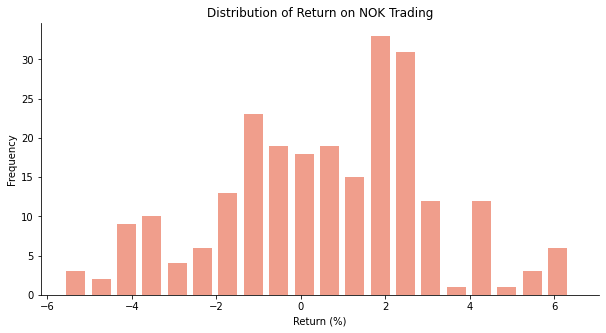

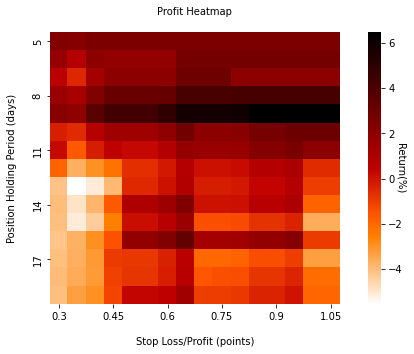

In [ ]:
#but thats not enough, we are not happy with the return
#come on, 2 percent return?
#i may as well as deposit the money into the current account
#and get 0.75% risk free interest rate
#therefore, we gotta try different holding period and stop loss/profit point
#the double loop is very slow, i almost wanna do it in julia
#plz go get a coffee or even lunch and dont wait for it


dic={}
for holdingt in range(5,20):
    for stopp in np.arange(0.3,1.1,0.05):
        signals=signal_generation(data,'brent','nok',oil_money,holding_threshold=holdingt, stop=stopp)

        p=portfolio(signals,'nok')
        dic[holdingt,stopp]=p['asset'].iloc[-1]/p['asset'].iloc[0]-1


profile=pd.DataFrame({'params':list(dic.keys()),'return':list(dic.values())})


# In[18]:

#plotting the distribution of return
#in average the return is 2%
#but we can get -6% and 6% as extreme values
#we want the largest positive return

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
profile['return'].apply(lambda x:x*100).hist(histtype='bar', color='#f09e8c',width=0.45,bins=20)
plt.title('Distribution of Return on NOK Trading')
plt.grid(False)
plt.ylabel('Frequency')
plt.xlabel('Return (%)')
plt.show()


# In[19]:

#plotting the heatmap of return under different parameters
#try to find the optimal parameters to maximize the return

#turn the dataframe into a matrix format first
matrix=pd.DataFrame(columns= [round(i,2) for i in np.arange(0.3,1.1,0.05)])

matrix['index']=np.arange(5,20)
matrix.set_index('index',inplace=True)

for i,j in profile['params']:
    matrix.at[i,round(j,2)]= profile['return'][profile['params']==(i,j)].item()*100

for i in matrix.columns:
    matrix[i]=matrix[i].apply(float)


#plotting
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
sns.heatmap(matrix,cmap='gist_heat_r',square=True, xticklabels=3,yticklabels=3)
ax.collections[0].colorbar.set_label('Return(%) \n', rotation=270)
plt.xlabel('\nStop Loss/Profit (points)')
plt.ylabel('Position Holding Period (days)\n')
plt.title('Profit Heatmap\n',fontsize=10)
plt.style.use('default')

#it seems like the return doesnt depend on the stop profit/loss point
#it is correlated with the length of holding period
#the ideal one should be 9 trading days
#as for stop loss/profit point could range from 0.6 to 1.05